# Working with polygons

At the core of each `SuperScreen` simulation is an instance of the `superscreen.Device` class, which represents the superconducting structure to be modeled. A `Device` is composed of one or more `Layers` that each lie in a plane parallel to the $x-y$ plane (at position `layer.z0`) and have a specified penetration depth $\Lambda$. Each layer contains one or more superconducting `films`, and each `film` contains zero or more `holes`. `Films` and `holes` are represented by instances of the `superscreen.Polygon` class, which defines a 2D polygonal region.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc

A `Polygon` is defined by a collection of `(x, y)` coordinates specifying its vertices; the vertices are stored as an `n x 2` `numpy.ndarray` called `polygon.points`.

In [2]:
# Define the initial geometry: a rectangular box specified as an np.ndarray
width, height = 10, 2
points = sc.geometry.box(width, height)
print(f"type(points) = {type(points)}, points.shape = {points.shape}")

type(points) = <class 'numpy.ndarray'>, points.shape = (100, 2)


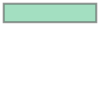

In [3]:
# Create a Polygon representing a "horizontal bar", hbar
hbar = sc.Polygon(points=points)
hbar.polygon

The object passed to `sc.Polygon(points=...)` can be of any of the following:

- An `n x 2` array-like object, for example an `np.ndarray` or a list of `(x, y)` coordinates
- An existing `sc.Polygon` instance (in which case, the new object will be a copy of the existing one)
- An instance of [LineString](https://shapely.readthedocs.io/en/stable/manual.html#LineString), [LinearRing](https://shapely.readthedocs.io/en/stable/manual.html#LinearRing), or [Polygon](https://shapely.readthedocs.io/en/stable/manual.html#Polygon) from the [shapely](https://shapely.readthedocs.io/en/stable/manual.html) package

In [4]:
(
    sc.Polygon(points=hbar.points)
    == sc.Polygon(points=hbar.polygon)
    == sc.Polygon(points=hbar)
    == hbar.copy()
    == hbar
)

True

Every instance of `sc.Polygon` has a property, `instance.polygon`, which returns a corresponding `shapely`
`Polygon` object. Among other things, this is usefuly for quickly visualizing polygons.

There are several methods for transforming the geometry of a single `Polygon`:

- `polygon.translate(dx=0, dy=0)`
- `polygon.rotate(degrees, origin=(0, 0))`
- `polygon.scale(xfact=1, yfact=1, origin=(0, 0))`
- `polygon.buffer(distance, ...)`

There are also three methods for combining multiple `Polygon`-like objects:

- `polygon.union(*others)`: logical union of `polygon` with each object in the iterable `others`
 - See also: `sc.Polygon.from_union([...])`
- `polygon.intersection(*others)`: logical intersection of `polygon` with each object in the iterable `others`
 - See also: `sc.Polygon.from_intersection([...])`
- `polygon.difference(*others)`: logical difference of `polygon` with each object in the iterable `others`
 - See also: `sc.Polygon.from_difference([...])`
 
Note that the elements of the iterable `others` can be of any type that can be passed in to `sc.Polygon(points=...)` (see above).

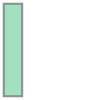

In [5]:
# Copy hbar and rotate the copy 90 degrees counterclockwise
vbar = hbar.rotate(90)
vbar.polygon

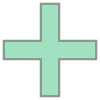

In [6]:
# Create a new Polygon that is the union of hbar and vbar: "+"
plus = hbar.union(vbar)
# # The above is equivalent to either of the following:
# plus = vbar.union(hbar)
# plus = sc.Polygon.from_union([hbar, vbar])
plus.polygon

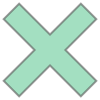

In [7]:
# Rotate the "+" by 45 degrees to make an "X"
X = plus.rotate(45)
X.polygon

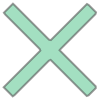

In [8]:
# Create a new polygon with all edges offset (eroded) by a distance of -0.5
thinX = X.buffer(-0.5)
thinX.polygon

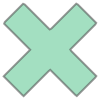

In [9]:
# Create a new polygon with all edges offset (expanded) by a distance of 0.5
thickX = X.buffer(0.5)
thickX.polygon

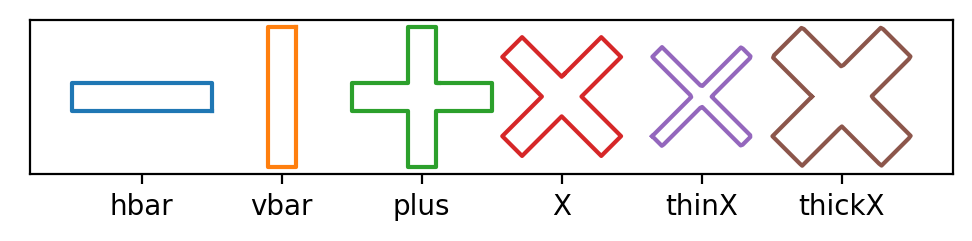

In [10]:
polygons = [hbar, vbar, plus, X, thinX, thickX]
labels = ["hbar", "vbar", "plus", "X", "thinX", "thickX"]

fig, ax = plt.subplots(figsize=(6, 1))

for i, polygon in enumerate(polygons):
    polygon.translate(dx=width * i).plot(ax=ax)

ax.set_xticks([width * i for i, _ in enumerate(labels)])
ax.set_xticklabels(labels)
_ = ax.set_yticks([])

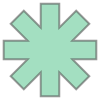

In [11]:
X.union(plus).polygon

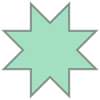

In [12]:
X.intersection(plus).polygon

Using the methods demonstrated above, intricate geometries can be constructed from simple building blocks in just a few lines of code.

In [13]:
size = 10

hbar = sc.Polygon(points=sc.geometry.box(size / 3, size / 50))
plus = hbar.union(hbar.rotate(90))
star = plus.union(plus.rotate(45))

star_dx = 1.2 * size * np.sqrt(2) / 2

snowflake = (
    sc.Polygon(points=sc.geometry.box(size, size))
    .rotate(45)
    .union(
        *(star.translate(dx=star_dx).rotate(degrees) for degrees in [0, 90, 180, 270])
    )
)
snowflake = snowflake.union(snowflake.rotate(45))

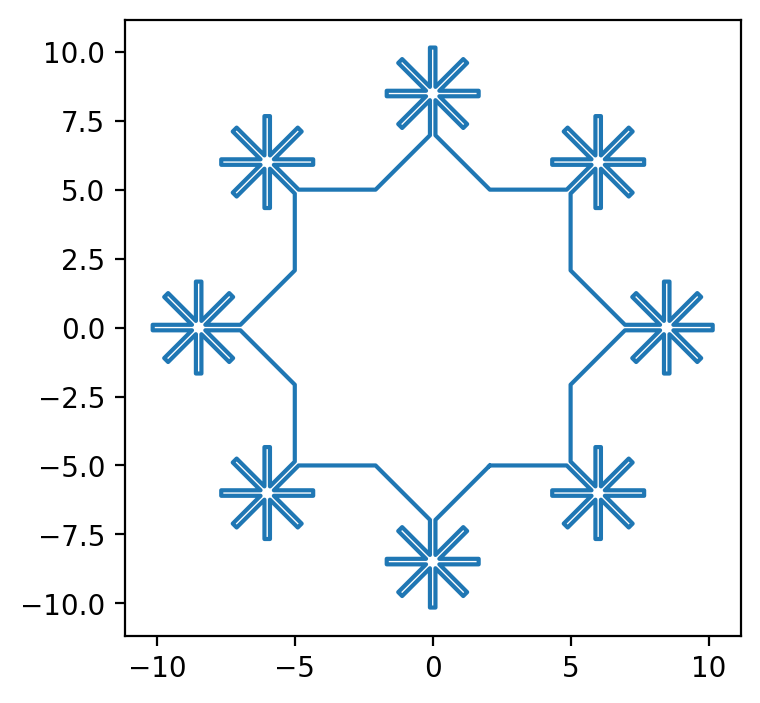

In [14]:
ax = snowflake.plot()

In [15]:
print(f"Polygon area: snowflake.area = {snowflake.area:.3f}")
print(f"Polygon width and height: snowflake.extents = {snowflake.extents}")

Polygon area: snowflake.area = 136.622
Polygon width and height: snowflake.extents = (20.303896081810475, 20.303896081810475)


In `SuperScreen`, all `polygons` must be simply-connected, i.e. have no holes.

In [16]:
circle = sc.Polygon(points=sc.geometry.circle(10))
hole = circle.scale(0.5, 0.5)
try:
    ring = circle.difference(hole)
except ValueError as e:
    print(f"ValueError('{e}')")

ValueError('Expected a simply-connected polygon.')


However, `SuperScreen` **does** allow you to model multiply-connected films. A `film` with $h$ `holes` in it is modeled as $h + 1$ separate `sc.Polygon` objects:

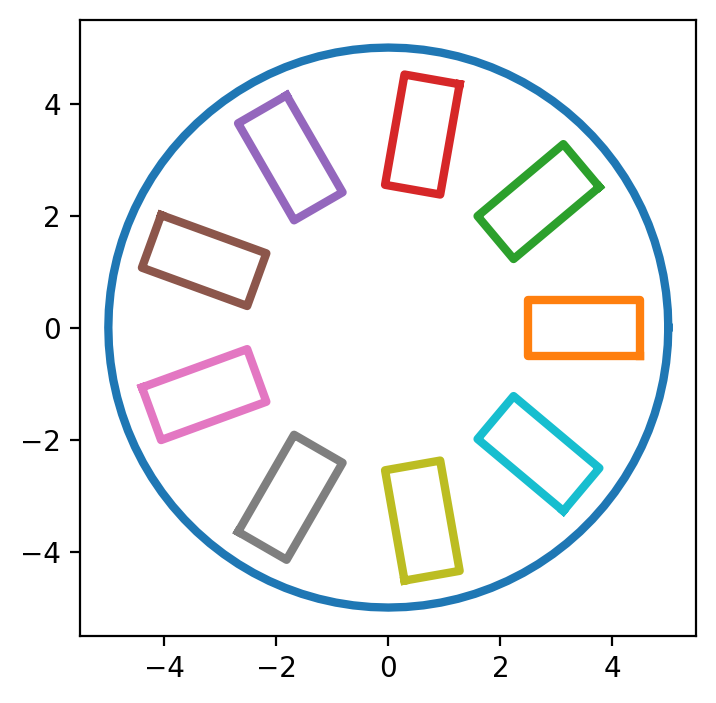

In [17]:
h = 9
circle = sc.Polygon(points=sc.geometry.circle(5))
holes = [
    sc.Polygon(points=sc.geometry.box(2, 1)).translate(3.5).rotate(theta)
    for theta in np.linspace(0, 360, h, endpoint=False)
]

ax = circle.plot(lw=3)
for hole in holes:
    hole.plot(ax=ax, lw=3)
    # Boolean array indicating whether each point in hole.points
    # lies within the circle
    points_in_circle = circle.contains_points(hole.points)
    assert isinstance(points_in_circle, np.ndarray)
    assert points_in_circle.shape[0] == hole.points.shape[0]
    assert points_in_circle.dtype == np.dtype(bool)
    assert points_in_circle.all()

    # Alternatively, use shapely to check whehther the hole's polygon
    # lies within the circle's polygon
    assert circle.polygon.contains(hole.polygon)

## Meshing `Polygons`

Individual polygons can be meshed using the `Polygon.make_mesh()` method.

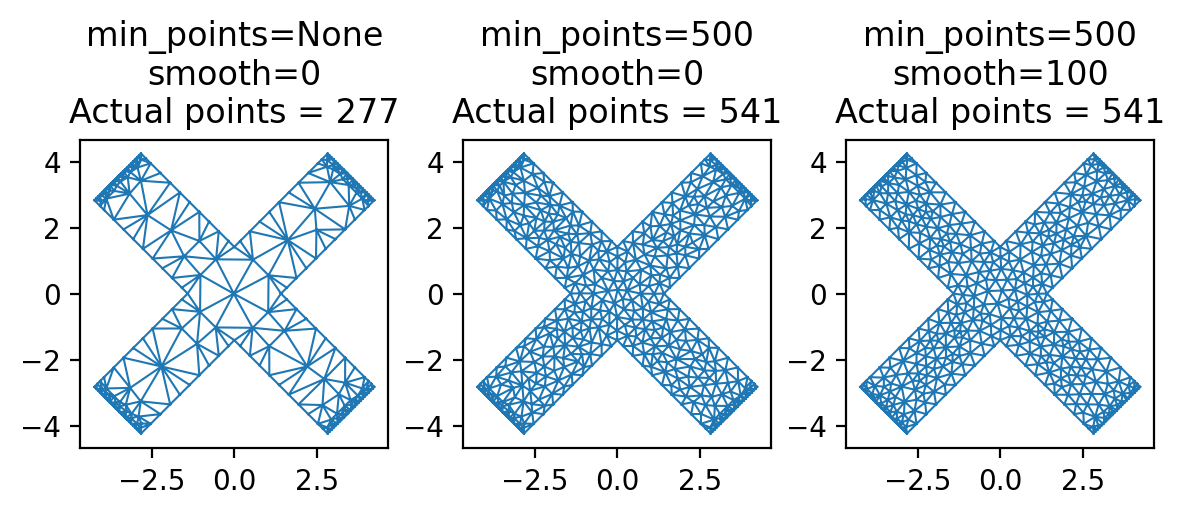

In [18]:
setups = [
    dict(min_points=None, smooth=0),
    dict(min_points=500, smooth=0),
    dict(min_points=500, smooth=100),
]

fig, axes = plt.subplots(1, len(setups), figsize=(2 * (len(setups) + 0.5), 2))

for ax, options in zip(axes, setups):
    # Generate a mesh with the specified options
    points, triangles = X.make_mesh(**options)

    # Plot the mesh
    ax.set_aspect("equal")
    title = [f"{key}={value!r}" for key, value in options.items()]
    title.append(f"Actual points = {points.shape[0]}")
    ax.triplot(points[:, 0], points[:, 1], triangles, linewidth=0.75)
    ax.set_title("\n".join(title))

This can come in handy if, for example, you want to use a `Polygon` to define an applied magnetic field rather than include it in a `Device` to solve.

Here we calculate the vector magnetic field from a magnetic "X" lying in the $x-y$ plane with uniform out-of-plane magnetization. We'll assume that the dimensions of the "X" are in microns and that its magnetization (area density of magnetic moments) is $\vec{m}=1\,\mu_\mathrm{B}/\mathrm{nm}^2\,\hat{z}$, where $\mu_\mathrm{B}$ is the Bohr magneton.

In [19]:
# Generate the mesh
points, triangles = X.make_mesh(min_points=1000)
x, y = points[:, 0], points[:, 1]

# (x, y, z) position of each vertex
vertex_positions = np.stack([x, y, np.zeros_like(x)], axis=1)

# Calculate the effective area of each vertex in the mesh
vertex_areas = sc.fem.mass_matrix(points, triangles) * sc.ureg("um ** 2")

# Define the magnetic moment of each mesh vertex
z_hat = np.array([0, 0, 1])  # unit vector in the z direction
magnetization = sc.ureg("1 mu_B / nm ** 2")
vertex_moments = z_hat * magnetization * vertex_areas[:, np.newaxis]
# Convert to units of Bohr magnetons
vertex_moments = vertex_moments.to("mu_B").magnitude

The function `superscreen.sources.DipoleField` returns a `superscreen.Parameter` that calulates the magnetic field (in Tesla) from a disribution of magnetic dipoles.

In [20]:
field_param = sc.sources.DipoleField(
    dipole_positions=vertex_positions,
    dipole_moments=vertex_moments,
)

Evaluate the magnetic field from the "X":

In [21]:
# Coordinates at which to evaluate the magnetic field (in microns)
N = 101
eval_xs = eval_ys = np.linspace(-5, 5, N)
eval_z = 0.5
xgrid, ygrid, zgrid = np.meshgrid(eval_xs, eval_ys, eval_z)
xgrid = np.squeeze(xgrid)
ygrid = np.squeeze(ygrid)
zgrid = np.squeeze(zgrid)

# field_param returns shape (N * N, 3), where the last axis is field component
# and the units are Tesla
field = field_param(xgrid.ravel(), ygrid.ravel(), zgrid.ravel()) * sc.ureg("tesla")
# Reshape to (N, N, 3), where the last axis is field component,
# and convert to microTesla
field = field.reshape((N, N, 3)).to("microtesla").magnitude

Plot the results:

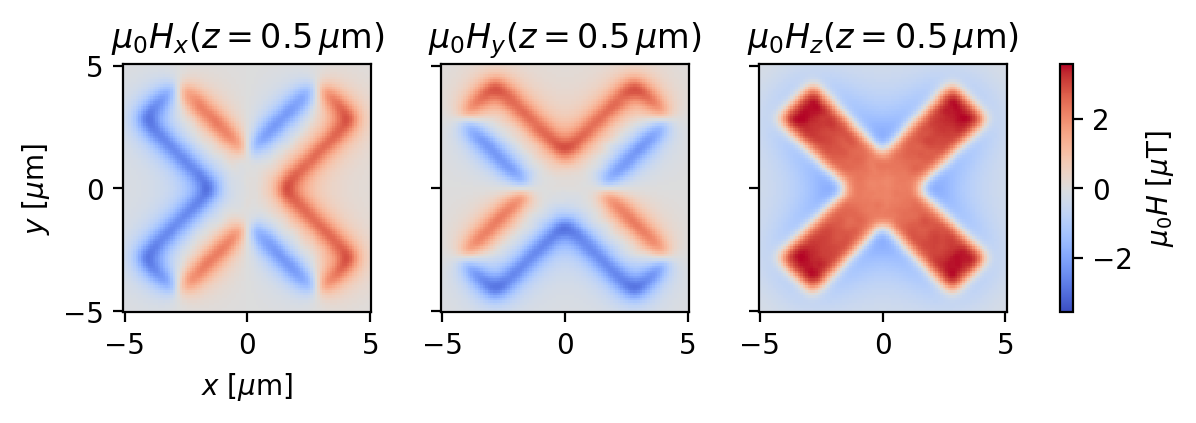

In [22]:
fig, axes = plt.subplots(
    1, 3, figsize=(6, 2), sharex=True, sharey=True, constrained_layout=True
)

vmax = max(abs(field.min()), abs(field.max()))
vmin = -vmax
kwargs = dict(vmin=vmin, vmax=vmax, shading="auto", cmap="coolwarm")

for i, (ax, label) in enumerate(zip(axes, "xyz")):
    ax.set_aspect("equal")
    im = ax.pcolormesh(xgrid, ygrid, field[..., i], **kwargs)
    ax.set_title(f"$\\mu_0H_{{{label}}}(z={{{eval_z}}}\\,\\mu\\mathrm{{m}})$")
cbar = fig.colorbar(im, ax=axes)
cbar.set_label("$\\mu_0H$ [$\\mu$T]")
_ = axes[0].set_xlabel("$x$ [$\\mu$m]")
_ = axes[0].set_ylabel("$y$ [$\\mu$m]")

In [23]:
sc.version_table()

Software,Version
SuperScreen,0.8.0
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
ray,2.0.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
